In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
h5py.enable_ipython_completer()

In [2]:
from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.hdf5 as io
from ATARI.theory.xs import SLBW


In [3]:
# syndat.particle_pair()

In [4]:
%matplotlib widget

In [5]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})


In [6]:
# create an energy domain, min/max
E_min_max = [550, 600]
# E_min_max =[3.5, 2550]

### or just give the min/max and the experiment object will do the above
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)


181

In [7]:
case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/test.hdf5'
dataset_range = (0, 10)
spin_groups = [ (3.0,1,0) ]
# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups )    

# vary_Erange = {'fullrange':(3,1000), 'maxres':5 , 'prob':0.01}
vary_Erange = None

samples_not_generated = generate(Ta_pair, exp, 
                                    'syndat_SLBW', 
                                    dataset_range, 
                                    case_file,
                                    fixed_resonance_ladder=None, 
                                    open_data=None,
                                    vary_Erange=vary_Erange,
                                    use_hdf5=True,
                                    overwrite = False
                                                                )
print(samples_not_generated)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Determine the parameter grid I should be working on

For right now, this grid is uniform for each parameter ($E_{\lambda}, \Gamma_{tot}$). In the future, we could consider a non-uniform grid to decrease problem size.

The bounds for $E_{\lambda}$ are informed by the window and the bounds for $\Gamma_{tot}$ will be informed by PT.

In [17]:
from scipy import integrate
from ATARI.PiTFAll.sample_case import fine_egrid
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.sammy_interface.sammy_interface import solve_bayes
from ATARI.utils.stats import chi2_val
from ATARI.atari_io.internal import fill_resonance_ladder


spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

samples = 10
decimals = 2

MSE_prior = np.zeros((decimals, samples))
MSE_posterior = np.zeros((decimals, samples))
Gnx_s = []

chi2_true = np.zeros((decimals, samples))
chi2_prior = np.zeros((decimals, samples))
chi2_posterior = np.zeros((decimals, samples))

for d in range(decimals):
    for i in range(samples):
        resonance_ladder = Ta_pair.sample_resonance_ladder(exp.energy_domain, spin_groups, average_parameters)
        rounded_ladder = resonance_ladder.__deepcopy__()

        rounded_ladder['E'] = np.round(resonance_ladder.E, d)
        # Gnx = rounded_ladder.apply(lambda row: gn2G(row), axis=1)
        rounded_ladder = fill_resonance_ladder(rounded_ladder, Ta_pair)
        Gnx_s.extend(np.array(rounded_ladder['Gnx']))
        # rounded_ladder_tot = np.round(Gnx,d) + np.round(rounded_ladder['Gg'],d)
        # rounded_ladder['Gnx'] = rounded_ladder_tot - np.round(rounded_ladder['Gg'],d)
        # rounded_ladder['gnx2'] = rounded_ladder.apply(lambda row: G2gn(row), axis=1)
        # rounded_ladder['gnx2'][rounded_ladder['gnx2']==0] = 0.001

        true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
        n = exp.redpar.val.n #0.067166 # atoms per barn or atoms/(1e-12*cm^2)
        df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-n*true)})
        prior, _, _ = SLBW(exp.energy_domain, Ta_pair, rounded_ladder)
        df_prior = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-n*prior)})

        exp.run(df_true)
        posterior, posterior_par = solve_bayes(exp.trans, exp.CovT, rounded_ladder, Ta_pair,
                                                        model   = 'SLBW',
                                                        reaction = 'trans',
                                                        expertimental_corrections = 'no_exp',
                                                        sammy_runDIR='SAMMY_runDIR',
                                                        keep_runDIR = True,  
                                                        one_spingroup = True
                                                                                                )
        
        # cov
        [df.sort_values('E', axis=0, ascending=False, inplace=True) for df in [df_true, df_prior, posterior, exp.trans]]
        [df.reset_index(drop=True, inplace=True) for df in [df_true, df_prior, posterior, exp.trans]]

        chi2_true[d, i] = chi2_val(df_true.theo_trans,exp.trans.exp_trans,exp.CovT)
        chi2_prior[d, i] = chi2_val(df_prior.theo_trans,exp.trans.exp_trans,exp.CovT)
        chi2_posterior[d, i] = chi2_val(posterior.theo_trans_bayes,exp.trans.exp_trans,exp.CovT)
        
        fineE = fine_egrid(df_true.E)
        true, _, _ = SLBW(fineE, Ta_pair, resonance_ladder)
        prior, _, _ = SLBW(fineE, Ta_pair, rounded_ladder)
        posterior, _, _ = SLBW(fineE, Ta_pair, rounded_ladder)
        
        MSE_prior[d, i] = integrate.trapezoid((true-prior)**2, fineE)
        # MSE_prior[d, i] = integrate.trapezoid((true-prior)**2, fineE)


In [20]:
# figure()
# errorbar(posterior.E, posterior.exp_trans, yerr=posterior.exp_trans_unc, fmt='.')
# plot(posterior.E, posterior.theo_trans)
# plot(posterior.E, posterior.theo_trans_bayes, 'r')
# plot(df_true.E, df_true.theo_trans, 'g')
# # plot(exp.trans.E, np.sqrt(np.diag(exp.CovT)), 'r')

# print(chi2_true[d,i])
# print(chi2_prior[d,i])
# print(chi2_posterior[d,i])

# print( np.sum((df_true.theo_trans-exp.trans.exp_trans)**2) )
# print( np.sum((posterior.theo_trans-exp.trans.exp_trans)**2) )
# print( np.sum((posterior.theo_trans_bayes-exp.trans.exp_trans)**2) )

# from ATARI.syndat.sammy_interface import readlst
# test = readlst("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/fitting_lite/SAMMY_runDIR/SAMMY.LST")


In [21]:
np.shape(chi2_prior)

(2, 10)

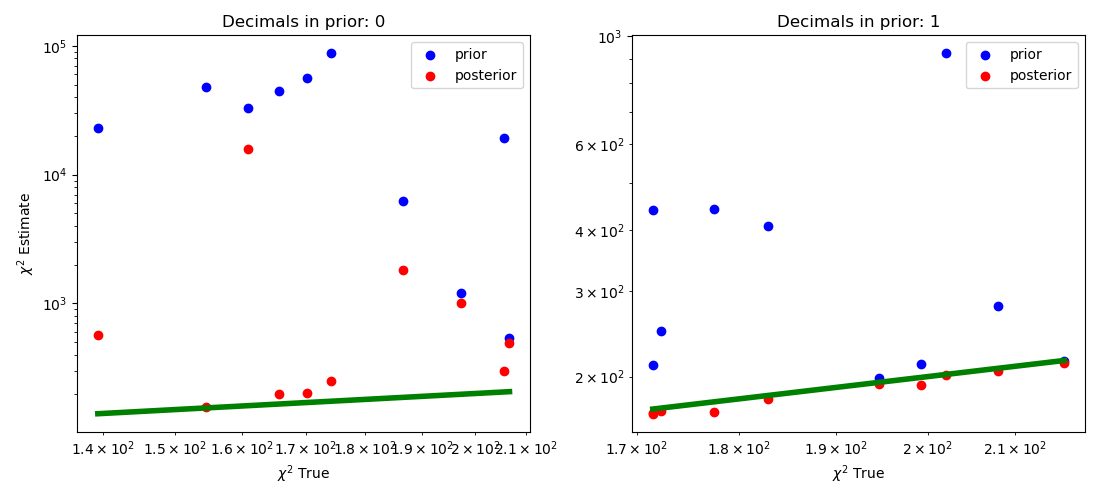

In [22]:
from matplotlib.ticker import ScalarFormatter
# from matplotlib.ticker import MaxNLocator
decimals = 0
fig, axes = subplots(1,2, figsize=(11,5))

for ax in axes:
    ax.scatter(chi2_true[decimals,:], chi2_prior[decimals,:], color='b', label='prior')
    ax.scatter(chi2_true[decimals,:], chi2_posterior[decimals,:], color='r', label='posterior')
    ax.plot(np.sort(chi2_true[decimals,:]), np.sort(chi2_true[decimals,:]), color='g', lw=4)
    ax.set_xlabel(r'$\chi^2$ True')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    # ax.set_xticks(ax.get_xticks(), rotation = 45)
    # ax.set_xlim((min(chi2_true[decimals,:])-10, max(chi2_true[decimals,:])+10))
    # ax.set_adjustable("datalim")
    # ax.tick_params(axis='both', which='major', labelsize=5)
    # ax.xaxis.set_scientific(False)
    # ax.xaxis.set_major_formatter(ScalarFormatter())
    # ax.ticklabel_format(axis='x', style='plain', scilimits=(-2,10))
    # ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
    # ax.get_xaxis().set_major_formatter(
    #     FuncFormatter(lambda x, p: format(int(x))))

    ax.set_title(f'Decimals in prior: {decimals}')

    decimals +=1


axes[0].set_ylabel(r'$\chi^2$ Estimate')
fig.tight_layout()
# ax2.plot(chi2_prior[decimals,:]-chi2_true[decimals,:], '.', color='b', label='prior')       #chi2_true[decimals,:], 
# ax2.plot(chi2_posterior[decimals,:]-chi2_true[decimals,:], '.', color='r', label='posterior')       #chi2_true[decimals,:], 
# # ax2.set_xlabel(r'$\chi^2$ True')
# ax2.set_xlabel('sample')
# ax2.set_ylabel(r'$\chi^2_{est} - \chi^2_{true}$')
# ax2.legend()


In [23]:
# GB needed
ev = 50; dev = 0.1
evG = 30; devG = 0.1
epts = 200
(ev/dev)*(evG*devG)*epts*8/1e9

0.0024

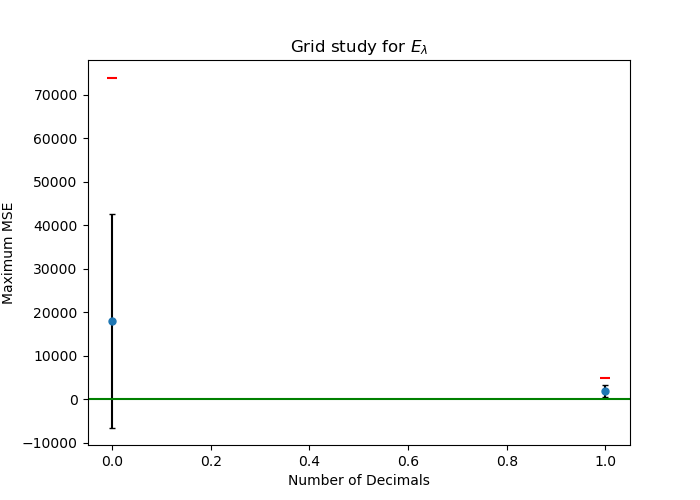

In [24]:
figure(figsize=(7,5))
errorbar(range(decimals), np.mean(MSE_prior, axis=1), yerr= np.std(MSE_prior, axis=1), fmt='.', ms = 10,capsize=2, ecolor='k')
scatter(range(decimals), np.max(MSE_prior, axis=1), marker='_', color='r', s=50)
xlabel('Number of Decimals')
ylabel('Maximum MSE')
title(r'Grid study for $E_{\lambda}$')
# title(r'Grid study for $G_{tot}$')
# ylim([-0.5,100])
# yscale('log')
axhline(y=0, color='g')

# figure()
# plot(df_prior.E, df_prior.theo_trans)
# plot(exp.energy_domain, posterior.theo_trans, 'r')

## Create initial feature matrix A and verify

Need to come back to this and fix the slight difference between sammy, syndat, and this matrix implementation

In [15]:
import scipy.stats as sts

Gnx_avg = np.mean(Gnx_s)
Gtot_avg = Gnx_avg + average_parameters['Gg']['3.0']
max_Gtot = sts.chi2.ppf(0.99, 1, loc=0, scale=Gnx_avg)/1 + average_parameters['Gg']['3.0']
min_Gtot = average_parameters['Gg']['3.0']
max_Gtot = max_Gtot*1e-3
min_Gtot = min_Gtot*1e-3
print(max_Gtot)
print(min_Gtot)

max_Elam = max(energy_grid) + Gtot_avg/2
min_Elam = min(energy_grid) - Gtot_avg/2
print(max_Elam)
print(min_Elam)


Elam_features = np.arange(min_Elam, max_Elam, 1e-1)
Gtot_features = np.arange(min_Gtot, max_Gtot, 1e-4)
print(len(Elam_features))
print(len(Gtot_features))

0.08618669335162572
0.064
633.6719697898691
516.3280302101309
1174
222


In [16]:
from ATARI.theory import scattering_params

# Elam_features = [575]
# Gtot_features = [0.075]

energy = exp.energy_domain
number_of_resonances = len(Elam_features)*len(Gtot_features)
Resonance_Matrix = np.zeros((len(energy), number_of_resonances))

E = energy
lwave = 0
S, P, phi, k = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
g = scattering_params.gstat(3.0, Ta_pair.I, Ta_pair.i)
kinematic_constant = (4*np.pi*g/k**2)
potential_scattering = kinematic_constant * np.sin(phi)**2


for iElam, Elam in enumerate(Elam_features):
    for iGtot, Gtot in enumerate(Gtot_features):

        SElam, PElam, phiElam, kElam = FofE_recursive([Elam], Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
        PPElam = P/PElam
        A_column = kinematic_constant * Gtot * ( Gtot*PPElam**2*np.cos(2*phi) /4 /((Elam-E)**2+(Gtot*PPElam/2)**2) 
                                                -(Elam-E)*PPElam*np.sin(2*phi) /2 /((Elam-E)**2+(Gtot*PPElam/2)**2) )  

        vertical_index = (iElam)*len(Gtot_features) + iGtot
        # print(vertical_index)
        Resonance_Matrix[:, vertical_index] = A_column

Gn_Gt = np.array([0.1]*number_of_resonances)
xs_tot = potential_scattering + Resonance_Matrix @ Gn_Gt

In [17]:
### Verify with Syndat and Sammy

# Gnx = Gn_Gt*np.tile(Gtot_features, len(Elam_features))
# testres = pd.DataFrame({'E':np.repeat(Elam_features, len(Gtot_features)), 'J':[3.0]*number_of_resonances, 'chs':[1.0]*number_of_resonances, 'lwave':[0.0]*number_of_resonances, 'J_ID':[1.0]*number_of_resonances, 'Gnx':Gnx})
# testres['gnx2'] = testres.apply(lambda row: G2gn(row), axis=1) #G2gn(testres) #
# testres['Gg'] = np.tile(Gtot_features, len(Elam_features))-Gnx
# testres['gnx2'] = testres['gnx2']*1e3
# testres['Gg'] = testres['Gg']*1e3
# testres['Gnx'] = testres['Gnx']*1e3
# # print(testres)
# test, _, _ = SLBW(E, Ta_pair, testres)

# from ATARI.sammy_interface.sammy_interface import calculate_xs
# lst = calculate_xs(E, testres,  Ta_pair,
#                                 model   = 'SLBW',
#                                 reaction = 'total',
#                                 expertimental_corrections = 'no_exp',
#                                 sammy_runDIR='SAMMY_runDIR',
#                                 keep_runDIR = False,  
#                                 one_spingroup = True
#                                                                         )


# figure()
# plot(E, xs_tot[0], lw=7, color ='k', label='matrix')
# plot(E, test, lw=4, color='g', label='syndat')
# plot(lst.E, lst.theo_xs, lw=1, color='r', label='sammy')
# yscale('log')

# # # plot(E, np.flipud(xs_tot[0])-test)
# # plot(E, np.flipud(lst.theo_xs)-test, label='Sammy vs Syndat')
# # plot(E, np.flipud(lst.theo_xs)-xs_tot[0], label='Sammy vs Matrix')

# legend()
# xscale('log')

In [18]:
# S, P, phi, k = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
# g = scattering_params.gstat(3.0, Ta_pair.I, Ta_pair.i)

# kinematic_constant = (4*np.pi*g/k**2)
# potential_scattering = kinematic_constant * np.sin(phi)**2

#     SElam, PElam, phiElam, kElam = FofE_recursive([El], Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
#     PPElam = P/PElam
#     A_column = kinematic_constant * Gt * ( Gt*PPElam**2*np.cos(2*phi) /4 /((El-E)**2+(Gt*PPElam/2)**2) 
#                                             -(El-E)*PPElam*np.sin(2*phi) /2 /((El-E)**2+(Gt*PPElam/2)**2) )                        
 
# Gn_Gt = 0.1
# xs_tot = potential_scattering + A_column * Gn_Gt

### Convert experimental transmission to experimental cross section

This is done s.t. we can solve the linear algebra optimization problem. It is not linear in transmission space.

In [19]:
from scipy.linalg import block_diag

xs_theo = (-1/exp.redpar.val.n)*np.log(exp.theo.theo_trans)
xs_exp = (-1/exp.redpar.val.n)*np.log(exp.trans.exp_trans)

exp.theo['theo_xs'] = xs_theo
exp.trans['exp_xs'] = xs_exp

dXi_dn = (1/exp.redpar.val.n**2) * np.log(exp.theo.theo_trans)
dXi_dT = (-1/exp.redpar.val.n) * (1/exp.theo.theo_trans)

Jac = np.vstack((np.diag(dXi_dT),dXi_dn))
CovT = block_diag(exp.CovT,exp.redpar.unc.n**2)
CovXS = Jac.T @ CovT @ Jac

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


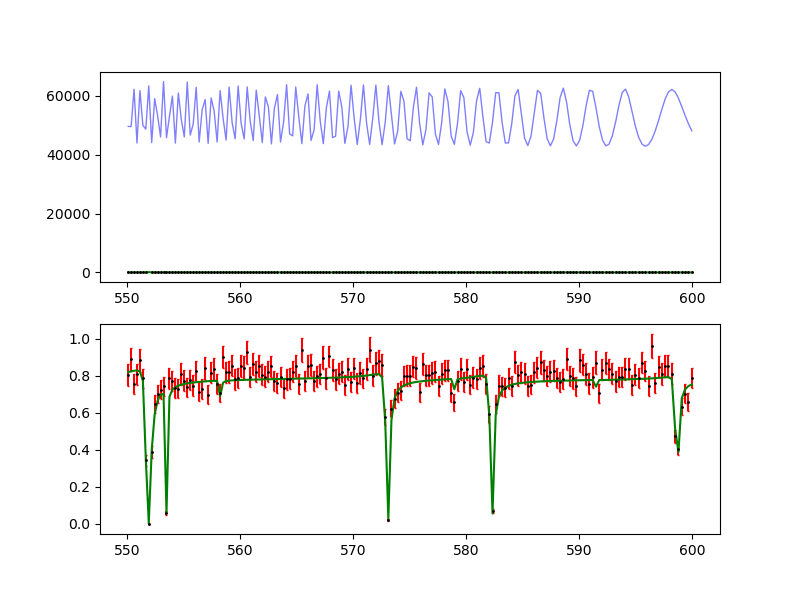

In [20]:
fig, axes = subplots(2,1, figsize=(8,6))
axes[0].errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
axes[0].plot(exp.theo.E, exp.theo.theo_xs, color='g')
axes[0].plot(E,xs_tot[0], color='b', alpha=0.5, lw=1,label='init')

axes[1].errorbar(exp.trans.E, exp.trans.exp_trans, yerr=np.sqrt(np.diag(exp.CovT)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
axes[1].plot(exp.theo.E, exp.theo.theo_trans, color='g')
# yscale('log')